In [6]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, MaxPooling3D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

2024-10-11 14:21:33.634621: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 14:21:34.198004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 14:21:35.455878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# Load training data
df_train = pd.read_csv('../Datasets/RefSeq.csv')
X_train = np.array(df_train[['fr1', 'fr2', 'fr3', 'fr4', 'fr5', 'fr6', 'fr7', 'fr8', 'fr9', 'fr10', 'fr11', 'fr12', 'fr13', 'fr14', 'fr15', 'fr16']]).astype('float32')
y_train = np.array(df_train['class'])
y_train = LabelEncoder().fit_transform(y_train)

# Load test data
df_test = pd.read_csv('../Datasets/CompSeq.csv')
X_test = np.array(df_test[['fr1', 'fr2', 'fr3', 'fr4', 'fr5', 'fr6', 'fr7', 'fr8', 'fr9', 'fr10', 'fr11', 'fr12', 'fr13', 'fr14', 'fr15', 'fr16']]).astype('float32')
y_test = np.array(df_test['class'])
y_test = LabelEncoder().fit_transform(y_test)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data to match Conv3D input
num_features = X_train_scaled.shape[1]
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, 1, num_features, 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, 1, num_features, 1)

# Split the training data into training and validation sets
from sklearn.model_selection import train_test_split
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Custom function for 3D data augmentation
def augment_data(X):
    if X.shape[1] <= 1 or X.shape[2] <= 1:
        return X
    zoom_factor = np.random.uniform(0.8, 1.2)
    new_height = max(int(X.shape[1] * zoom_factor), 1)
    new_width = max(int(X.shape[2] * zoom_factor), 1)
    X_augmented = tf.image.resize(X, (new_height, new_width))
    return X_augmented.numpy()

# Create a generator for the training data
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.X))

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_indexes]
        y_batch = self.y[batch_indexes]
        X_batch = np.array([augment_data(x) for x in X_batch])
        return X_batch, y_batch

In [8]:
# Create the model
def create_improved_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv3D(32, kernel_size=(1, 1, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D(pool_size=(1, 1, 1)),  # Adjusted pooling size to avoid dimension issues
        Dropout(0.3),
        Conv3D(64, kernel_size=(1, 1, 3), activation='relu'),
        MaxPooling3D(pool_size=(1, 1, 1)),  # Adjusted pooling size to avoid dimension issues
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
input_shape = (1, 1, num_features, 1)
improved_cnn_model = create_improved_cnn_model(input_shape, len(np.unique(y_train)))

/home/kav_k/anaconda3/envs/myEnv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-11 14:21:39.604170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-11 14:21:39.820531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-11 14:21:39.820612: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

In [9]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

In [10]:
# Create the custom data generators
train_generator = CustomDataGenerator(X_train_final, y_train_final, batch_size=64)
val_generator = CustomDataGenerator(X_val, y_val, batch_size=64)

In [11]:
# Train the model
start_train = time.time()
history = improved_cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=300,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
end_train = time.time()
print("Training Evaluation Time: {0:.5} seconds \n".format(end_train - start_train))

Epoch 1/300


/home/kav_k/anaconda3/envs/myEnv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728636701.731437  239352 service.cc:145] XLA service 0x7f1a2c009690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728636701.731473  239352 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-10-11 14:21:41.763852: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-11 14:21:41.897222: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN versio

   94/13108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.0135 - loss: 5.3677      

I0000 00:00:1728636707.385443  239352 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13108/13108 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6352 - loss: 1.4792 - val_accuracy: 0.9876 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 2/300
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9716 - loss: 0.0874 - val_accuracy: 0.9934 - val_loss: 0.0210 - learning_rate: 0.0010
Epoch 3/300
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9831 - loss: 0.0527 - val_accuracy: 0.9966 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 4/300
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.9883 - loss: 0.0375 - val_accuracy: 0.9974 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 5/300
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9903 - loss: 0.0311 - val_accuracy: 0.9980 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 6/300
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9918 - loss: 0.0269 - val_accuracy: 0.9988 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 7/300
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accu

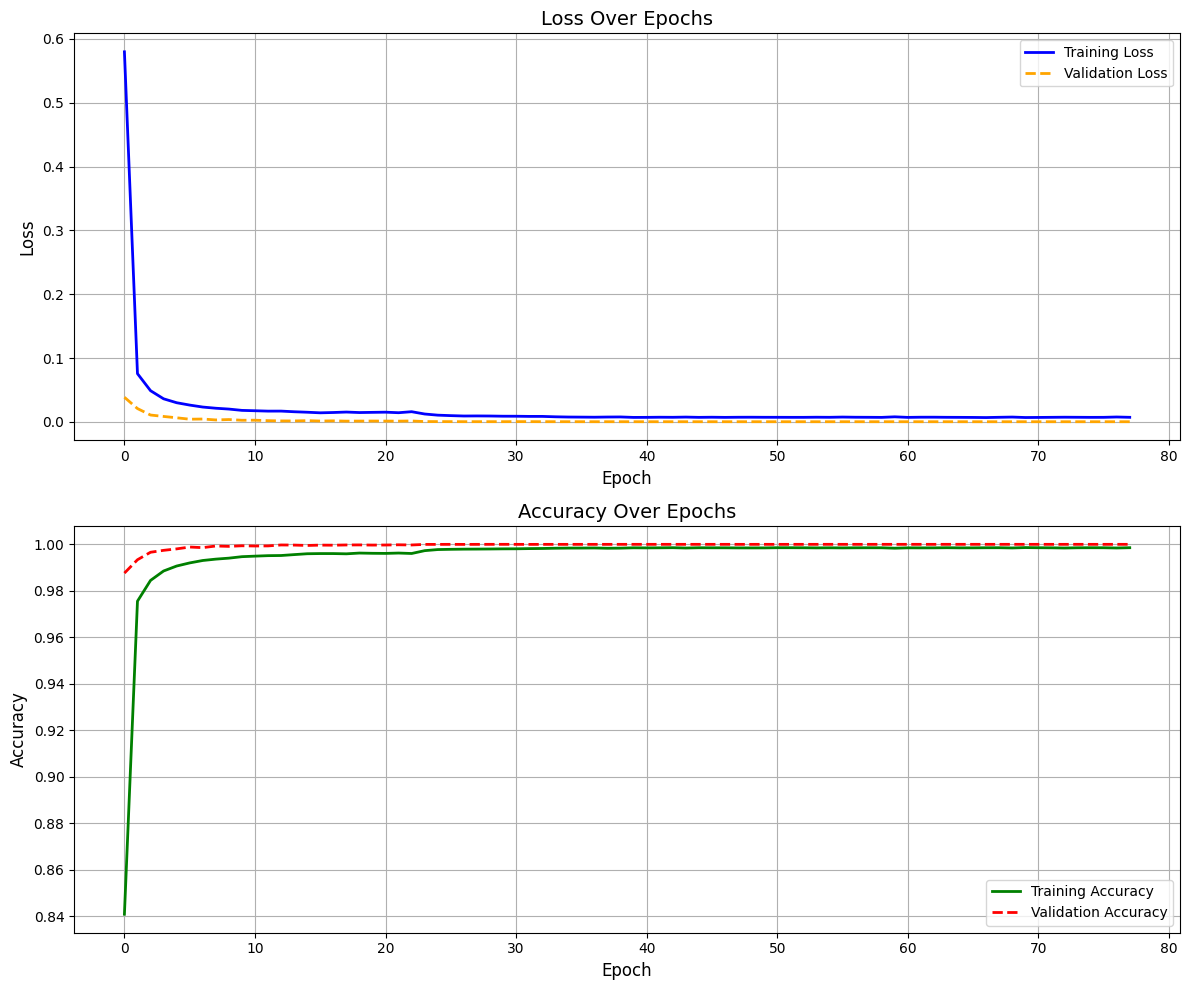

In [19]:
# Plotting the learning curves
plt.figure(figsize=(12, 10))

# Plot the training and validation loss over epochs
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)

# Plot the training and validation accuracy over epochs
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--', linewidth=2)
plt.title('Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
start = time.time()
# Evaluate the model on the test set
test_loss, test_accuracy = improved_cnn_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy}")

# Predictions
predictions = improved_cnn_model.predict(X_test_scaled)
predicted_classes = np.argmax(predictions, axis=1)
end = time.time()
print("Testing Evaluation Time: {0:.5} seconds \n".format(end-start))

I0000 00:00:1728639362.843881  260881 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 8 bytes spill stores, 8 bytes spill loads



Test Accuracy: 0.9997100830078125
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [14]:
# Calculate metrics
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes, average='macro')
recall = recall_score(y_test, predicted_classes, average='macro')
f1 = f1_score(y_test, predicted_classes, average='macro')

# Print metrics
print("Accuracy   :", accuracy)
print("Precision  :", precision)
print("Recall     :", recall)
print("F1 Score   :", f1)

Accuracy   : 0.9997100830078125
Precision  : 0.9996978022249339
Recall     : 0.9997894665877803
F1 Score   : 0.9997424875972785


In [15]:
# Save metrics to a CSV file
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv('../Metrics_Files/CNN_Metrics.csv', index=False)
print("Metrics stored into CNN_Metrics.csv")

Metrics stored into CNN_Metrics.csv


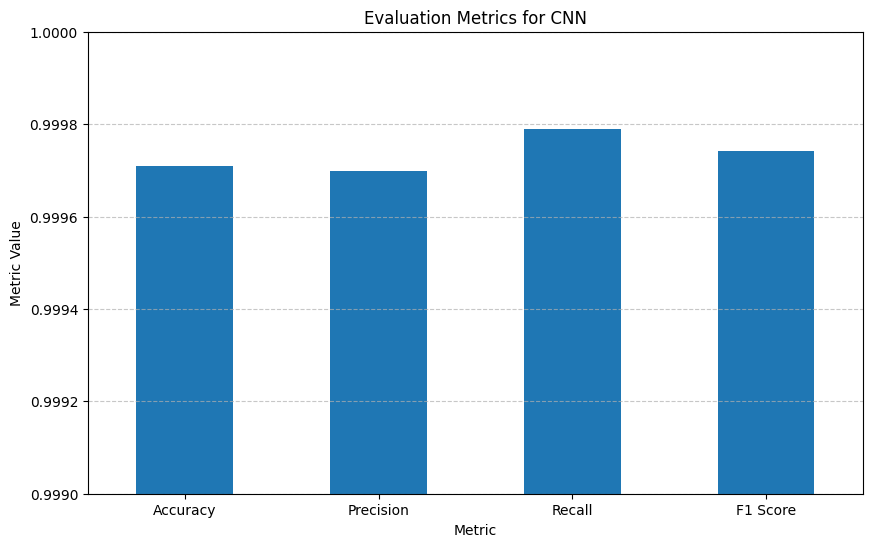

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '../Metrics_Files/CNN_Metrics.csv'  # Replace with your actual file path
metrics_df = pd.read_csv(file_path)

# Set the metric as the index for better visualization
metrics_df.set_index('Metric', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(metrics_df))  # Use seaborn's husl palette

# Create a bar plot
metrics_df['Value'].plot(kind='bar')

# Customizing the plot
plt.title('Evaluation Metrics for CNN')
plt.ylabel('Metric Value')
plt.ylim(0.999, 1)  # Set the y-axis limit
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid for better readability
plt.show()